# RSA pix2pix

We performed pixel-by-pixel RSA encryption of the image, which is a dictionary-based version of the algorithm.

In [1]:
import cv2
import numpy as np
import random
import os
import sys
import tqdm
import time
import matplotlib.pyplot as plt
from math import isqrt
from concurrent.futures import ThreadPoolExecutor

## Loading image
RSA.jpg is a picture with a resolution of 8K, and RSA2.jpg is a picture with a resolution of 853*1280.

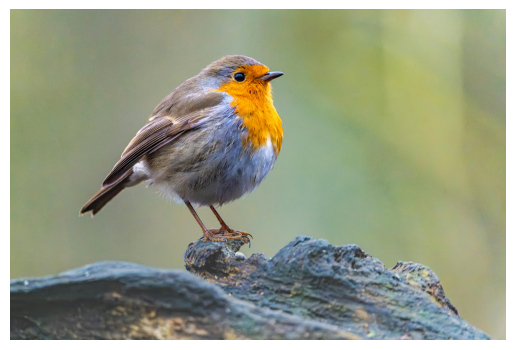

Image shape:  (5461, 8192, 3)
Max pixel value:  255


In [2]:
img = cv2.imread('RSA.jpg')
#img = cv2.imread('RSA2.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
h, w, c = img.shape
plt.imshow(img)
plt.axis('off')
plt.show()
print("Image shape: ", img.shape)
# Extract the maximum pixel value
max_pixel = int(np.max(img))
print("Max pixel value: ", max_pixel)

In [3]:
def prime_test(n, k=100):
    s, d = 0, n - 1
    while d % 2 == 0:
        s, d = s + 1, d // 2
    for _ in range(k):
        a = random.randint(2, n - 2)
        x = pow(a, d, n)
        if x == 1 or x == n - 1:
            continue
        for _ in range(s - 1):
            x = pow(x, 2, n)
            if x == n - 1:
                break
        else:
            return False
    return True

def prime(bits):
    i = 0
    while True:
        i += 1
        p = random.getrandbits(bits)
        p |= (1 << bits - 1) | 1
        if prime_test(p):
            return p, i
        
def gcd(a, b):
    while b:
        a, b = b, a % b
    return a

## Generate Large Prime Numbers

Alice generates two large prime numbers `p` and `q` .

In [4]:
bits = 2048
ts = time.time()
p, pi = prime(bits)
q, qi = prime(bits)
while p == q:
    q, qii = prime(bits)
    qi += qii

print(f"prime number a generated after {pi} iterations:", p)
print(f"prime number b generated after {qi} iterations:", q)
print(f"Time taken for generate primes: {time.time() - ts:.2f} seconds")

prime number a generated after 326 iterations: 19216497412018882413779852844326285228169024281957731206511390830722920679307202295358238107171310248488745165029157722038747380204739244824301113284336816088621882628780509575142888582866505793954230257428932272336848454540579598906366817248675908725858885076782689715949268750443257298139751321332644395467614229716011566335736926167028915436643352658929895539231517495229520561030885112828522879076552041384145120134515511167749453970682091918564353913777804331195718381751971305980067973340060832214676856437551325757689935637755182527657188875552712028048774018067462504250438720674707550570099328137332597964991
prime number b generated after 524 iterations: 163201979737437079493508739100423176955786953984116935752183094328097848190865479120253101912672470822658344397059271970714127614662875621751096822706742375419374093518800753680147603057664444991575993346992624532776185753219051427697509749012770606145942432253408376012729029605684401466

## Generate Keys

Alice generates a public key and a private key, where `(N, e)` is the public key and `(N, d)` is the private key. Alice sends her public key `(N, e)` to Bob and hides her private key `(N, d)`.

Destroy the records of `p` and `q`.

In [5]:
ts_t = time.time()
N = p * q
r = (p - 1) * (q - 1)
e = 65537
while gcd(e, r) != 1:
    e = random.randint(1, r)
d = pow(e, -1, r)
print(f"public key: ({N}, {e})")
print(f"private key: ({N}, {d})")
del p, q, r

public key: (313617042126081772491094240231709652581683448334491057670530993871898020521819982548243999367408249896041728519686181532665858707709968284995123828247440749475481410193274927385668802480626134640893330277881087303329115812509247056212869324563928325123274538643513836466636265540590240979193080997317121573455619319736234144978403885054080258886860279172494601920005236973414965864189723632242353913399542611677682184197918690937959852410991402110878525245931190374384972936505407263855033750142808971457521696810541191571848278226061432160177927969195600333116242710627078337813181069738597365214305109825125312794713027847616988718491944770151388267253269279088413990585719111218236317519675881440809399964250015197587808283773699232524238417960194815749310078554289797719847920585085753850899754393210660169806956748280427831821235262719822968448109307032846849354531258855546749346175400384358223306587557743550665816624467733039488780667549727730876623362119337123221990431323846278

## Encrypted Image
Detect the maximum pixel value of the image.

Then fill the encrypted values ​​of the corresponding pixel values ​​in a list indexed from 0 to the maximum pixel value to generate a dictionary.

Then replace the entire image to generate an encrypted image.

In [6]:
ts = time.time()
L = N.bit_length()
l = int(max_pixel).bit_length()
if L < l:
    raise ValueError("Unable to encrypt: The number of digits in N is less than the maximum number of digits in a pixel")

# Create the encryption dictionary
dict_c = []
for i in range(max_pixel + 1):
    dict_c.append(pow(i, e, N))

# Encrypt the entire image
img_c = []
for i in range(h):
    img_c.append([])
    for j in range(w):
        img_c[i].append([])
        for k in range(c):
            img_c[i][j].append(dict_c[img[i][j][k]])

print("Image encrypted in", time.time() - ts, "seconds")
print("Total encryption time:", time.time() - ts, "seconds")
del dict_c, img

Image encrypted in 43.46323204040527 seconds
Total encryption time: 43.46323204040527 seconds


## Decrypting the image
Collect all non-repeated encrypted values ​​to generate an encrypted dictionary.

Then decrypt the encrypted dictionary to generate a decrypted dictionary.

Rearrange the encrypted dictionary according to the value of the decrypted dictionary. The index of the generated new dictionary is the pixel value, and the value corresponding to the index is the encrypted value.

Replace the encrypted image to generate the decrypted image.

Dictionary decrypted in 28.57250428199768 seconds
Image decrypted in 126.23862552642822 seconds


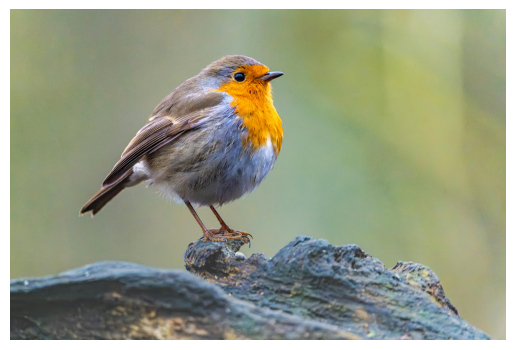

Total decryption time: 183.13739156723022 seconds
Total time taken: 226.62058115005493 seconds


In [7]:
ts = time.time()
dict_c = set()
for img_h in img_c:
    for img_w in img_h:
        for img__c in img_w:
            dict_c.add(img__c)
dict_c = list(dict_c)
ts_d = time.time()
dict_d = dict_c.copy()
for i in dict_c:
    dict_d[pow(i, d, N)] = i
print("Dictionary decrypted in", time.time() - ts_d, "seconds")
ts_dc = time.time()
img_dc = np.zeros((h, w, c)).astype(int)
for i in range(h):
    for j in range(w):
        for k in range(c):
            img_dc[i][j][k] = dict_d.index(img_c[i][j][k])
print("Image decrypted in", time.time() - ts_dc, "seconds")
plt.imshow(img_dc)
plt.axis('off')
plt.show()
print("Total decryption time:", time.time() - ts, "seconds")
print("Total time taken:", time.time() - ts_t, "seconds")